---

This notebook contains code to re-create **Figure 9** from:

*Gaussian Process Modeling to Recover Faraday Depth Spectra*, 2020, Simon W. Ndiritu, Anna M. M. Scaife, David L. Tabb, Miguel Carcamo & Joe Hanson

**Note:** The flagging and noise realisations implemented in this notebook are stochastic, so the figure will have the same properties as the one that appears in the paper but is unlikely to be identical.

---

In [1]:
import numpy as np
import pylab as pl
import itertools

In [2]:
from celerite_base import *
from faraday_stuff import *

In [3]:
pl.rcParams['figure.figsize'] = [10, 5]
pl.rcParams['figure.dpi'] = 300

---

Set seed for reproducibility

In [4]:
np.random.seed(39) # steps

---
### Create data

In [5]:
p1 = [100.,100.,100.,25.,25.,25.,25.,25.,25.,25.,25.,25.,25.,0.0,1.80,0.0,1.80]
phi1=[500.10,49.38,4.96,-37.84,-37.84,-37.84,-44.55,232.56,-37.83,-37.84,149.50,-232.56,-44.55,0.0,-240.22,0.0,-240.0]
chi1=[40.,60.,60.,0.,-40.,-40.,0.0,40.,-40.,0.0,40.,0.0,0.0,0.0,-36.,0.,-36.]

def faraday_thin(p0,phi,chi,l2):

    chi*=np.pi/180.
    p = p0*np.exp(2*1j*(chi+phi*l2))

    return p

In [6]:
const_c = 3e8

channels = 300 
freq_min = 1.1e9 
freq_max = 1.4e9
freq     = np.linspace(freq_min, freq_max, channels)
l2       = (const_c/freq)**2

In [7]:
phi = np.linspace(-1000,1000,10000)

In [8]:
model=0

In [9]:
p = faraday_thin(p1[model],phi1[model],chi1[model],l2)

In [10]:
pI = np.mean(np.sqrt(np.real(p)**2+np.imag(p)**2))
snr = pI*np.sqrt(len(l2))
f_snr = 32./snr
p*=f_snr

In [11]:
modq, modu = np.real(p), np.imag(p)

In [12]:
amp = np.mean(np.sqrt(np.real(p)**2+np.imag(p)**2))
sigma = 1/np.sqrt(channels)
print(amp)
print(sigma)
print(amp/sigma)

1.8475208614068022
0.05773502691896257
32.0


---
Make GP estimate:

In [13]:
noise = 1.0

stokesQn = np.real(p)+np.random.normal(loc =0.0, scale=noise, size = len(p))
stokesUn = np.imag(p)+np.random.normal(loc =0.0, scale=noise, size = len(p))

In [14]:
# optimize hyper-parameters of GP and make a prediction:
GP = MyCelerite(noise)
GP.celerite_optimize(l2, stokesQn, stokesUn)
mu_q, std_q, mu_u, std_u = GP.celerite_predict(stokesQn, stokesUn, l2[::-1])

In [15]:
fspec_gp = []
for i in range(0,len(phi)):
    fspec_gp.append(calc_f(phi[i],l2[::-1],mu_q,mu_u,np.ones(len(l2))))

---
Make QU prediction:

In [16]:
delta = 1.57
p = f_snr*faraday_thin(p1[model],phi1[model]+delta,chi1[model],l2)
pred1q, pred1u = np.real(p), np.imag(p)

delta = 0.60
p = f_snr*faraday_thin(p1[model],phi1[model]+delta,chi1[model],l2)
pred2q, pred2u = np.real(p), np.imag(p)

delta = 3.60
p = f_snr*faraday_thin(p1[model],phi1[model]+delta,chi1[model],l2)
pred3q, pred3u = np.real(p), np.imag(p)

---
### Create Faraday depth spectra

In [17]:
fmod = []
fpred1, fpred2, fpred3 = [], [], []

w = np.ones(len(modq))

for i in range(0,len(phi)):
    fmod.append(calc_f(phi[i],l2,modq,modu,w))
    fpred1.append(calc_f(phi[i],l2,pred1q,pred1u,w))
    fpred2.append(calc_f(phi[i],l2,pred2q,pred2u,w))
    fpred3.append(calc_f(phi[i],l2,pred3q,pred3u,w))
    
    
fmod = np.array(fmod)
fpred1 = np.array(fpred1)
fpred2 = np.array(fpred2)
fpred3 = np.array(fpred3)

In [18]:
fnoise = 1.0/np.sqrt(channels)
print(fnoise)

0.05773502691896257


---
Make residuals

In [19]:
res1q = modq - pred1q
res1u = modu - pred1u

res2q = modq - pred2q
res2u = modu - pred2u

res3q = modq - pred3q
res3u = modu - pred3u

In [20]:
fres1, fres2, fres3 = [], [], []
for i in range(0,len(phi)):
    fres1.append(calc_f(phi[i],l2,res1q,res1u,w))
    fres2.append(calc_f(phi[i],l2,res2q,res2u,w))
    fres3.append(calc_f(phi[i],l2,res3q,res3u,w))
    
fres1 = np.array(fres1)
fres2 = np.array(fres2)
fres3 = np.array(fres3)

In [21]:
resq = modq - mu_q[::-1]
resu = modu - mu_u[::-1]

In [22]:
fres_gp = []
for i in range(0,len(phi)):
    fres_gp.append(calc_f(phi[i],l2,resq,resu,w))
    
fres_gp = np.array(fres_gp)

---
### Make plot

In [23]:
pl.rcParams['figure.figsize'] = [20, 10]
pl.rcParams['figure.dpi'] = 300

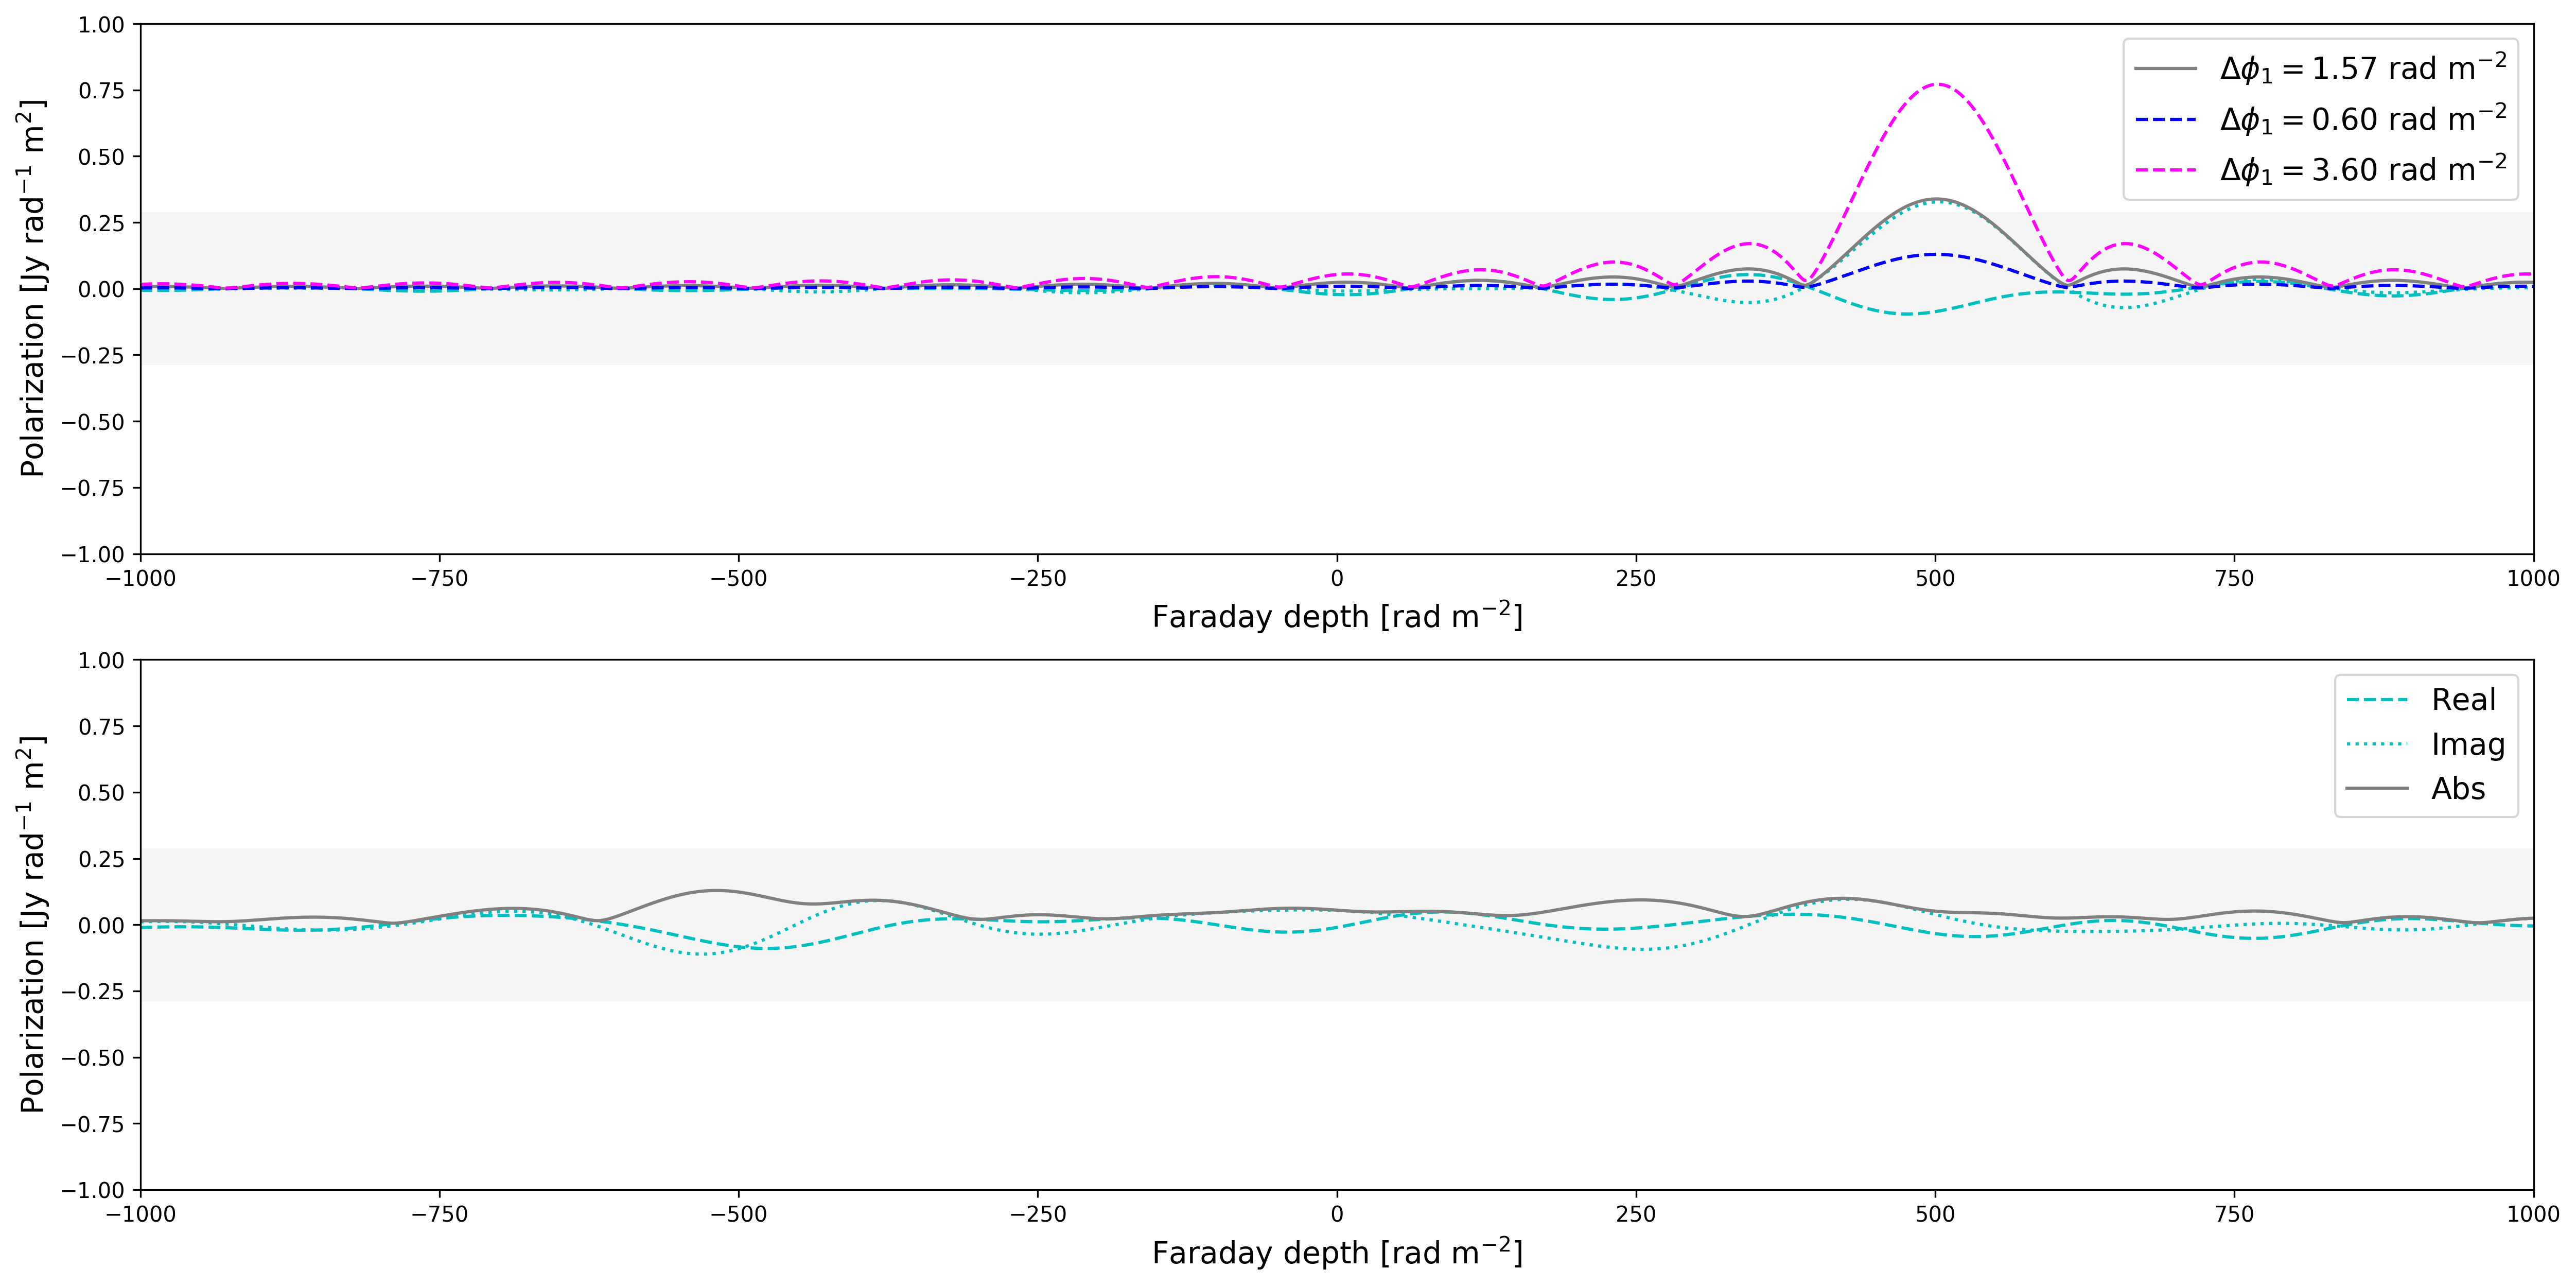

In [24]:
pl.subplot(211)
pl.fill_between([-1000,1000],[-5*fnoise,-5*fnoise],[5*fnoise,5*fnoise], facecolor='whitesmoke')
pl.plot(phi,np.real(fres1),ls='--',c='c')
pl.plot(phi,np.imag(fres1),ls=':',c='c')
pl.plot(phi,np.abs(fres1),ls='-',c='grey',label=r"$\Delta \phi_1 = 1.57$ rad m$^{-2}$") 
pl.plot(phi,np.abs(fres2),ls='--',c='blue',label=r"$\Delta \phi_1 = 0.60$ rad m$^{-2}$") 
pl.plot(phi,np.abs(fres3),ls='--',c='magenta',label=r"$\Delta \phi_1 = 3.60$ rad m$^{-2}$") 
pl.xlim(-1000,1000)
pl.ylim(-1,1)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=14)
pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=14)
pl.legend(fontsize=14)

pl.subplot(212)
pl.fill_between([-1000,1000],[-5*fnoise,-5*fnoise],[5*fnoise,5*fnoise], facecolor='whitesmoke')
pl.plot(phi,np.real(fres_gp),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fres_gp),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fres_gp),ls='-',c='grey',label="Abs")    
pl.xlim(-1000,1000)
pl.ylim(-1,1)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=14)
pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=14)
pl.legend(fontsize=14)

pl.show()